In [78]:
import os
import matplotlib.pyplot as plt
import numpy as np
import jax
from functools import reduce,partial
from itertools import chain
from jax.tree_util import tree_map_with_path,tree_map,tree_transpose,tree_structure,keystr,tree_leaves
jax.config.update('jax_platform_name', 'cpu')
import pickle as pkl
from collections import OrderedDict
import os
import operator
from multiprocessing.pool import ThreadPool
import multiprocessing
from tqdm import tqdm
from utils import *

def get_ckpt_paths(path, subfolder):
    if os.path.exists(os.path.join(path,"settings.json")):

        path = os.path.join(path,subfolder)
        files = [f for f in os.listdir(path)]
        files = sorted(files, key = lambda f : int(f.split(".")[0]))

        return OrderedDict([(int(f.split(".")[0]),os.path.join(path,f)) for f in files])
    else:
        dicts = [get_ckpt_paths(os.path.join(path,run),subfolder) for run in os.listdir(os.path.join(path))]
        return tree_map(lambda *e : [*e], *dicts)


def load(path):

    if not type(path) == list:
        path = [path]

    ckpt = []
    for p in path:
        with open(p, "rb") as f:
            ckpt.append(pkl.load(f))
    
    return tree_map(lambda *e : np.concatenate([*e]), *ckpt)

def get_stats(path, subfolder):

    stats = {i : load(p) for i,p in get_ckpt_paths(path, subfolder).items()}
    acc = {key : value["acc"] for key,value in stats.items()}
    loss = {key : value["loss"] for key,value in stats.items()}

    return {"acc" : acc, "loss" : loss}

def plot_step_stat(stats, ax, label=None):

    x = stats.keys()
    mean = np.asarray(list(tree_map(lambda y : np.mean(y),stats).values()))
    std = np.asarray(list(tree_map(lambda y : np.std(y),stats).values()))
    ax.plot(x, mean, label=label)
    ax.fill_between(x, mean-std, mean+std, alpha=0.3)

def get_subexpspaths(path, skip=None):
    for subpath in os.listdir(path):
        if skip:
            if skip(subpath):
                continue
        yield os.path.join(path,subpath),subpath

def max_acc(stats):
    return np.max(np.stack(list(stats["acc"].values())),axis=0)

def plot_hyperparam_y(paths, x_fn, y_fn, ax, label=None, norm=True):
    x = []
    means = []
    stds = []
    for path,subpath in paths:
        y = y_fn(path)
        mean = np.mean(y)
        std = np.std(y)

        x.append(x_fn(subpath))
        means.append(mean)
        stds.append(std)

    x,means,stds = np.asarray(x),np.asarray(means),np.asarray(stds)
    argsort_indices = np.argsort(x).astype(np.int32)
    x,means,std = x[argsort_indices],means[argsort_indices],stds[argsort_indices]

    if norm:
        means_normed = (means-np.min(means))/(np.max(means)-np.min(means))
        stds_normed = (stds-np.min(stds))/(np.max(stds)-np.min(stds))
    else:
        means_normed = means
        stds_normed = stds

    ax.plot(x,means_normed, label=label)
    ax.fill_between(x, means_normed-stds_normed, means_normed+stds_normed, alpha=0.3)

    return (x,means,means_normed)


def estimate_convergence(stats, min_path_length = 10, error= 0.1):
    x = np.asarray(list(stats.keys()))
    y = np.asarray(list(stats.values()))

    step_at_max_acc = np.asarray([x[i] for i in y.argmax(axis=0)])
    
    variances = jnp.asarray([np.var(y[i:],axis=0) for i in range(y.shape[0]-min_path_length)])
    variances = variances - np.min(variances,axis=0) - error

    return step_at_max_acc,np.asarray([x[i] for i in variances.argmin(axis=0)])

    """
    @jax.jit
    @partial(jax.vmap, in_axes=(0,None))
    @partial(jax.vmap, in_axes=(None,0))
    def var_matrix(a,b):
        return jnp.abs((a-b))
    
    converged = []
    for i in range(variances.shape[0]):
        var_m = var_matrix(variances[i:],variances[i:])
        converged.append(jax.vmap(lambda e : jnp.all(e <= var_tol),in_axes=(-1))(var_m))
    converged = jnp.stack(converged).astype(jnp.int32)

    step_at_convergence = np.asarray([x[i] for i in converged.argmax(axis=0)])

    #acc_at_step_at_max_acc = y.max(axis=0)
    #acc_at_step_at_convergence = 
    return step_at_max_acc,step_at_convergence
    """

Max test accuracy of Standard is 85.8% with lr 0.025
Max test accuracy of norm is 85.87% with param 0.15
Max test accuracy of global_center_std_uncenter is 86.02% with param 0.15
Max test accuracy of wd is 81.15% with lambda 0.005


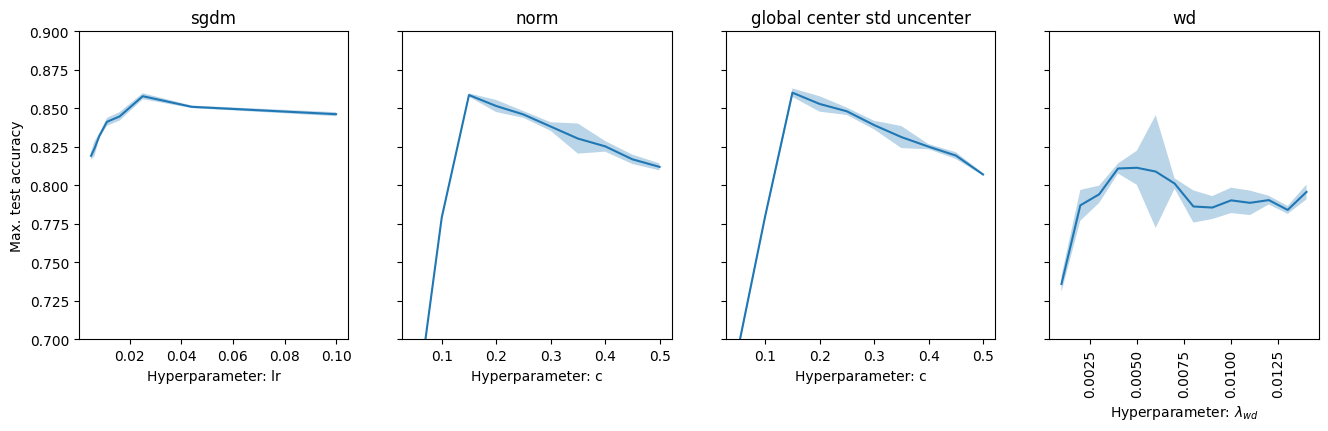

In [79]:
fig,axs = plt.subplots(ncols=4,nrows=1,sharey="row")
fig.set_size_inches(16,4)
axs[0].set_ylim(0.7,0.9) 

x,y,_ = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/standard"),
                               lambda subpath: float(subpath),lambda p : max_acc(get_stats(p,"test_stats")),axs[0], norm=False)
axs[0].set_title("sgdm")
axs[0].set_ylabel("Max. test accuracy")
axs[0].set_xlabel("Hyperparameter: lr")
print("Max test accuracy of Standard is {0}% with lr {1}".format(round(100*y.max(),2),round(x[y.argmax()],5)))

x,y,_ = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/norm",skip=lambda s : s.endswith("0")),
                               lambda subpath: float(subpath.split("_")[0]),lambda p : max_acc(get_stats(p,"test_stats")), axs[1], norm=False)
axs[1].set_title("norm")
#axs[1].set_ylabel("Max. test accuracy")
axs[1].set_xlabel("Hyperparameter: c")
print("Max test accuracy of norm is {0}% with param {1}".format(round(100*y.max(),2),round(x[y.argmax()],5)))

x,y,_ = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/global_center_std_uncenter"),
                               lambda subpath: float(subpath.split("_")[0]),lambda p : max_acc(get_stats(p,"test_stats")), axs[2], norm=False)
axs[2].set_title("global center std uncenter")
#axs[2].set_ylabel("Max. test accuracy")
axs[2].set_xlabel("Hyperparameter: c")
print("Max test accuracy of global_center_std_uncenter is {0}% with param {1}".format(round(100*y.max(),2),round(x[y.argmax()],5)))

x,y,_ = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/wd"),
                               lambda subpath: float(subpath),lambda p : max_acc(get_stats(p,"test_stats")), axs[3], norm=False)
axs[3].set_title("wd")
#axs[3].set_ylabel("Max. test accuracy")
axs[3].set_xlabel(r"Hyperparameter: $\lambda_{wd}$")
axs[3].tick_params(axis='x', labelrotation=90)
print("Max test accuracy of wd is {0}% with lambda {1}".format(round(100*y.max(),2),round(x[y.argmax()],5)))


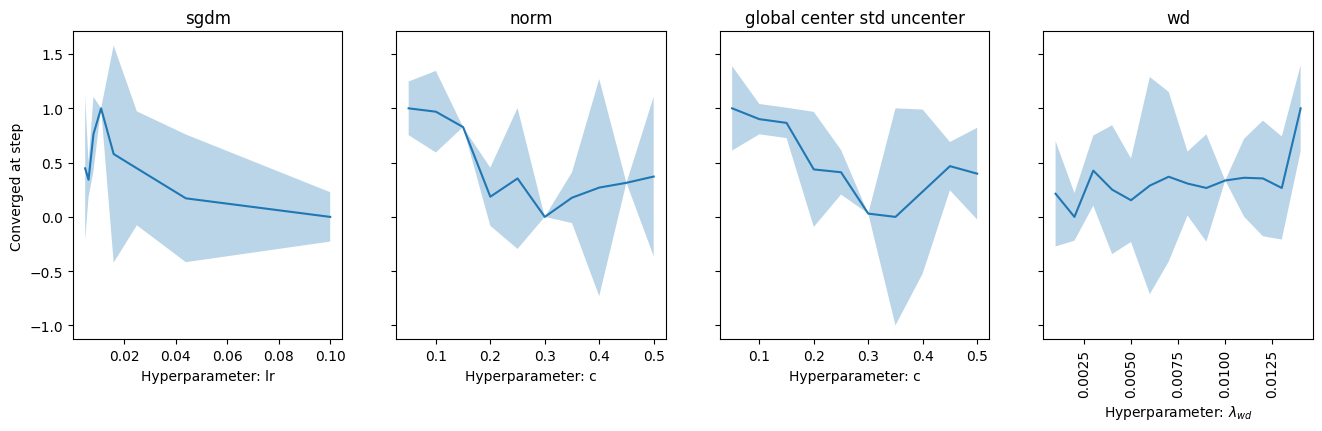

In [ ]:
fig,axs = plt.subplots(ncols=4,nrows=1,sharey="row")
fig.set_size_inches(16,4)

x,y,_ = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/standard"),
                               lambda subpath: float(subpath),lambda p : estimate_convergence(get_stats(p,"test_stats")["acc"])[1],axs[0], norm=False)
axs[0].set_title("sgdm")
axs[0].set_ylabel("Converged at step")
axs[0].set_xlabel("Hyperparameter: lr")

x,y,_ = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/norm",skip=lambda s : s.endswith("0")),
                               lambda subpath: float(subpath.split("_")[0]),lambda p : estimate_convergence(get_stats(p,"test_stats")["acc"])[1], axs[1], norm=False)
axs[1].set_title("norm")
axs[1].set_xlabel("Hyperparameter: c")

x,y,_ = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/global_center_std_uncenter"),
                               lambda subpath: float(subpath.split("_")[0]),lambda p : estimate_convergence(get_stats(p,"test_stats")["acc"])[1], axs[2], norm=False)
axs[2].set_title("global center std uncenter")
axs[2].set_xlabel("Hyperparameter: c")

x,y,_ = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/wd"),
                               lambda subpath: float(subpath),lambda p : estimate_convergence(get_stats(p,"test_stats")["acc"])[1], axs[3], norm=False)
axs[3].set_title("wd")
axs[3].set_xlabel(r"Hyperparameter: $\lambda_{wd}$")
axs[3].tick_params(axis='x', labelrotation=90)


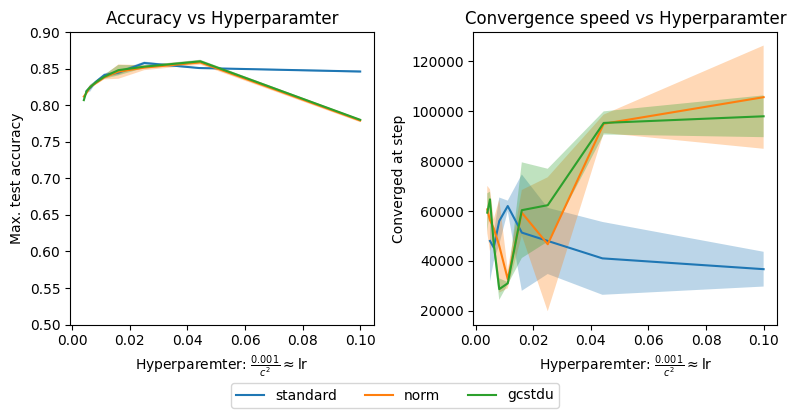

In [121]:
fig,axs = plt.subplots(ncols=2,nrows=1)
fig.set_size_inches(8,4)


x,y,_ = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/standard"),
                               lambda subpath: float(subpath),lambda p : max_acc(get_stats(p,"test_stats")), axs[0], norm=False,label="standard")

x,y,_ = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/norm",skip=lambda s : s.endswith("0") or float(s.split("_")[0]) < 0.1),
                               lambda subpath: 0.001/(float(subpath.split("_")[0]))**2,lambda p : max_acc(get_stats(p,"test_stats")), axs[0], norm=False,label="norm")

x,y,_ = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/global_center_std_uncenter",skip=lambda s : float(s.split("_")[0]) < 0.1),
                               lambda subpath: 0.001/(float(subpath.split("_")[0]))**2,lambda p : max_acc(get_stats(p,"test_stats")), axs[0], norm=False,label="gcstdu")

axs[0].set_xlabel("Hyperparemter: $\\frac{0.001}{c^2} \\approx$lr")
axs[0].set_ylim(0.5,0.9) 
axs[0].set_ylabel("Max. test accuracy")
axs[0].set_title("Accuracy vs Hyperparamter")

x,y,_ = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/standard"),
                               lambda subpath: float(subpath),lambda p : estimate_convergence(get_stats(p,"test_stats")["acc"])[1], axs[1], norm=False,label="standard")

x,y,_ = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/norm",skip=lambda s : s.endswith("0") or float(s.split("_")[0]) < 0.1),
                               lambda subpath: 0.001/(float(subpath.split("_")[0]))**2,lambda p : estimate_convergence(get_stats(p,"test_stats")["acc"])[1], axs[1], norm=False,label="norm")

x,y,_ = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/global_center_std_uncenter",skip=lambda s : float(s.split("_")[0]) < 0.1),
                               lambda subpath: 0.001/(float(subpath.split("_")[0]))**2,lambda p : estimate_convergence(get_stats(p,"test_stats")["acc"])[1], axs[1], norm=False,label="gcstdu")


axs[1].set_xlabel("Hyperparemter: $\\frac{0.001}{c^2} \\approx$lr")
axs[1].set_ylabel("Converged at step")
axs[1].set_title("Convergence speed vs Hyperparamter")

lines, labels = axs[1].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5,-0.05), bbox_transform=fig.transFigure)
fig.tight_layout()

Diff for standard: 0.69%
Diff for norm: 2.04%
Diff for gcstdu: 2.1%
Diff for wd: 2.74%


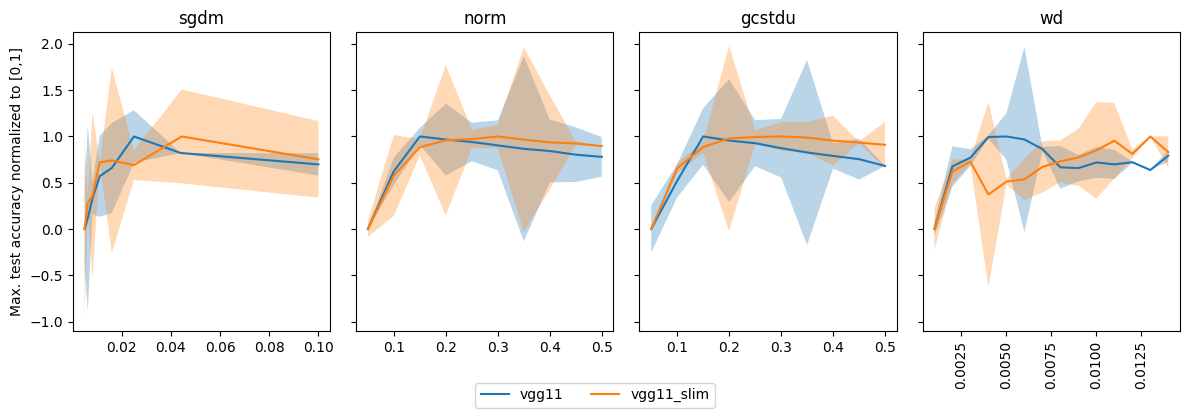

In [88]:
# Compare normal accuracy to accuracy over slim runs
fig,axs = plt.subplots(ncols=4,nrows=1,sharey="row")
fig.set_size_inches(12,4)
axs[0].set_ylabel("Max. test accuracy normalized to [0,1]")

_,y,y_normed = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/standard"),lambda subpath: float(subpath),lambda p : max_acc(get_stats(p,"test_stats")), axs[0], "standard")
_,y_slim,y_normed_slim = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/standard_slim"),lambda subpath: float(subpath),lambda p : max_acc(get_stats(p,"test_stats")), axs[0], "standard_slim")
print("Diff for standard: {0}%".format(round((np.max(y)-y[np.argmax(y_slim)])*100,2)))
#print("Corr for {0}: {1}".format("standard", np.corrcoef(y_standard_normed,y_standard_slim_normed)))
axs[0].set_title("sgdm")

_,y,y_normed = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/norm",skip=lambda s : s.endswith("0")),lambda subpath: float(subpath.split("_")[0]),
                                 lambda p : max_acc(get_stats(p,"test_stats")), axs[1], "norm")
_,y_slim,y_normed_slim = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/norm_slim"),lambda subpath: float(subpath.split("_")[0]),
                                           lambda p : max_acc(get_stats(p,"test_stats")), axs[1], "norm_slim")
print("Diff for norm: {0}%".format(round((np.max(y)-y[np.argmax(y_slim)])*100,2)))
#print("Corr for {0}: {1}".format("norm", np.corrcoef(y_norm_normed,y_norm_slim_normed)))
axs[1].set_title("norm")

_,y,y_normed = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/global_center_std_uncenter/"),lambda subpath: float(subpath.split("_")[0]),
                                 lambda p : max_acc(get_stats(p,"test_stats")), axs[2], "gcstdu")
_,y_slim,y_normed_slim = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/global_center_std_uncenter_slim/"),lambda subpath: float(subpath.split("_")[0]),
                                           lambda p : max_acc(get_stats(p,"test_stats")), axs[2], "gcstdu")
print("Diff for gcstdu: {0}%".format(round((np.max(y)-y[np.argmax(y_slim)])*100,2)))
#print("Corr for {0}: {1}".format("norm", np.corrcoef(y_norm_normed,y_norm_slim_normed)))
axs[2].set_title("gcstdu")

_,y,y_normed  = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/wd"),lambda subpath: float(subpath),lambda p : max_acc(get_stats(p,"test_stats")), axs[3], "wd")
_,y_slim,y_normed_slim = plot_hyperparam_y(get_subexpspaths("./exps_sgdm/wd_slim"),lambda subpath: float(subpath),lambda p : max_acc(get_stats(p,"test_stats")), axs[3], "wd_slim")
print("Diff for wd: {0}%".format(round((np.max(y)-y[np.argmax(y_slim)])*100,2)))
#print("Corr for {0}: {1}".format("wd", np.corrcoef(y_wd_normed,y_wd_slim_normed)))
axs[3].set_title("wd")
axs[3].tick_params(axis='x', labelrotation=90)

lines, _ = axs[0].get_legend_handles_labels()
labels = ["vgg11", "vgg11_slim"]
fig.legend(lines, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5,-0.05), bbox_transform=fig.transFigure)
fig.tight_layout()


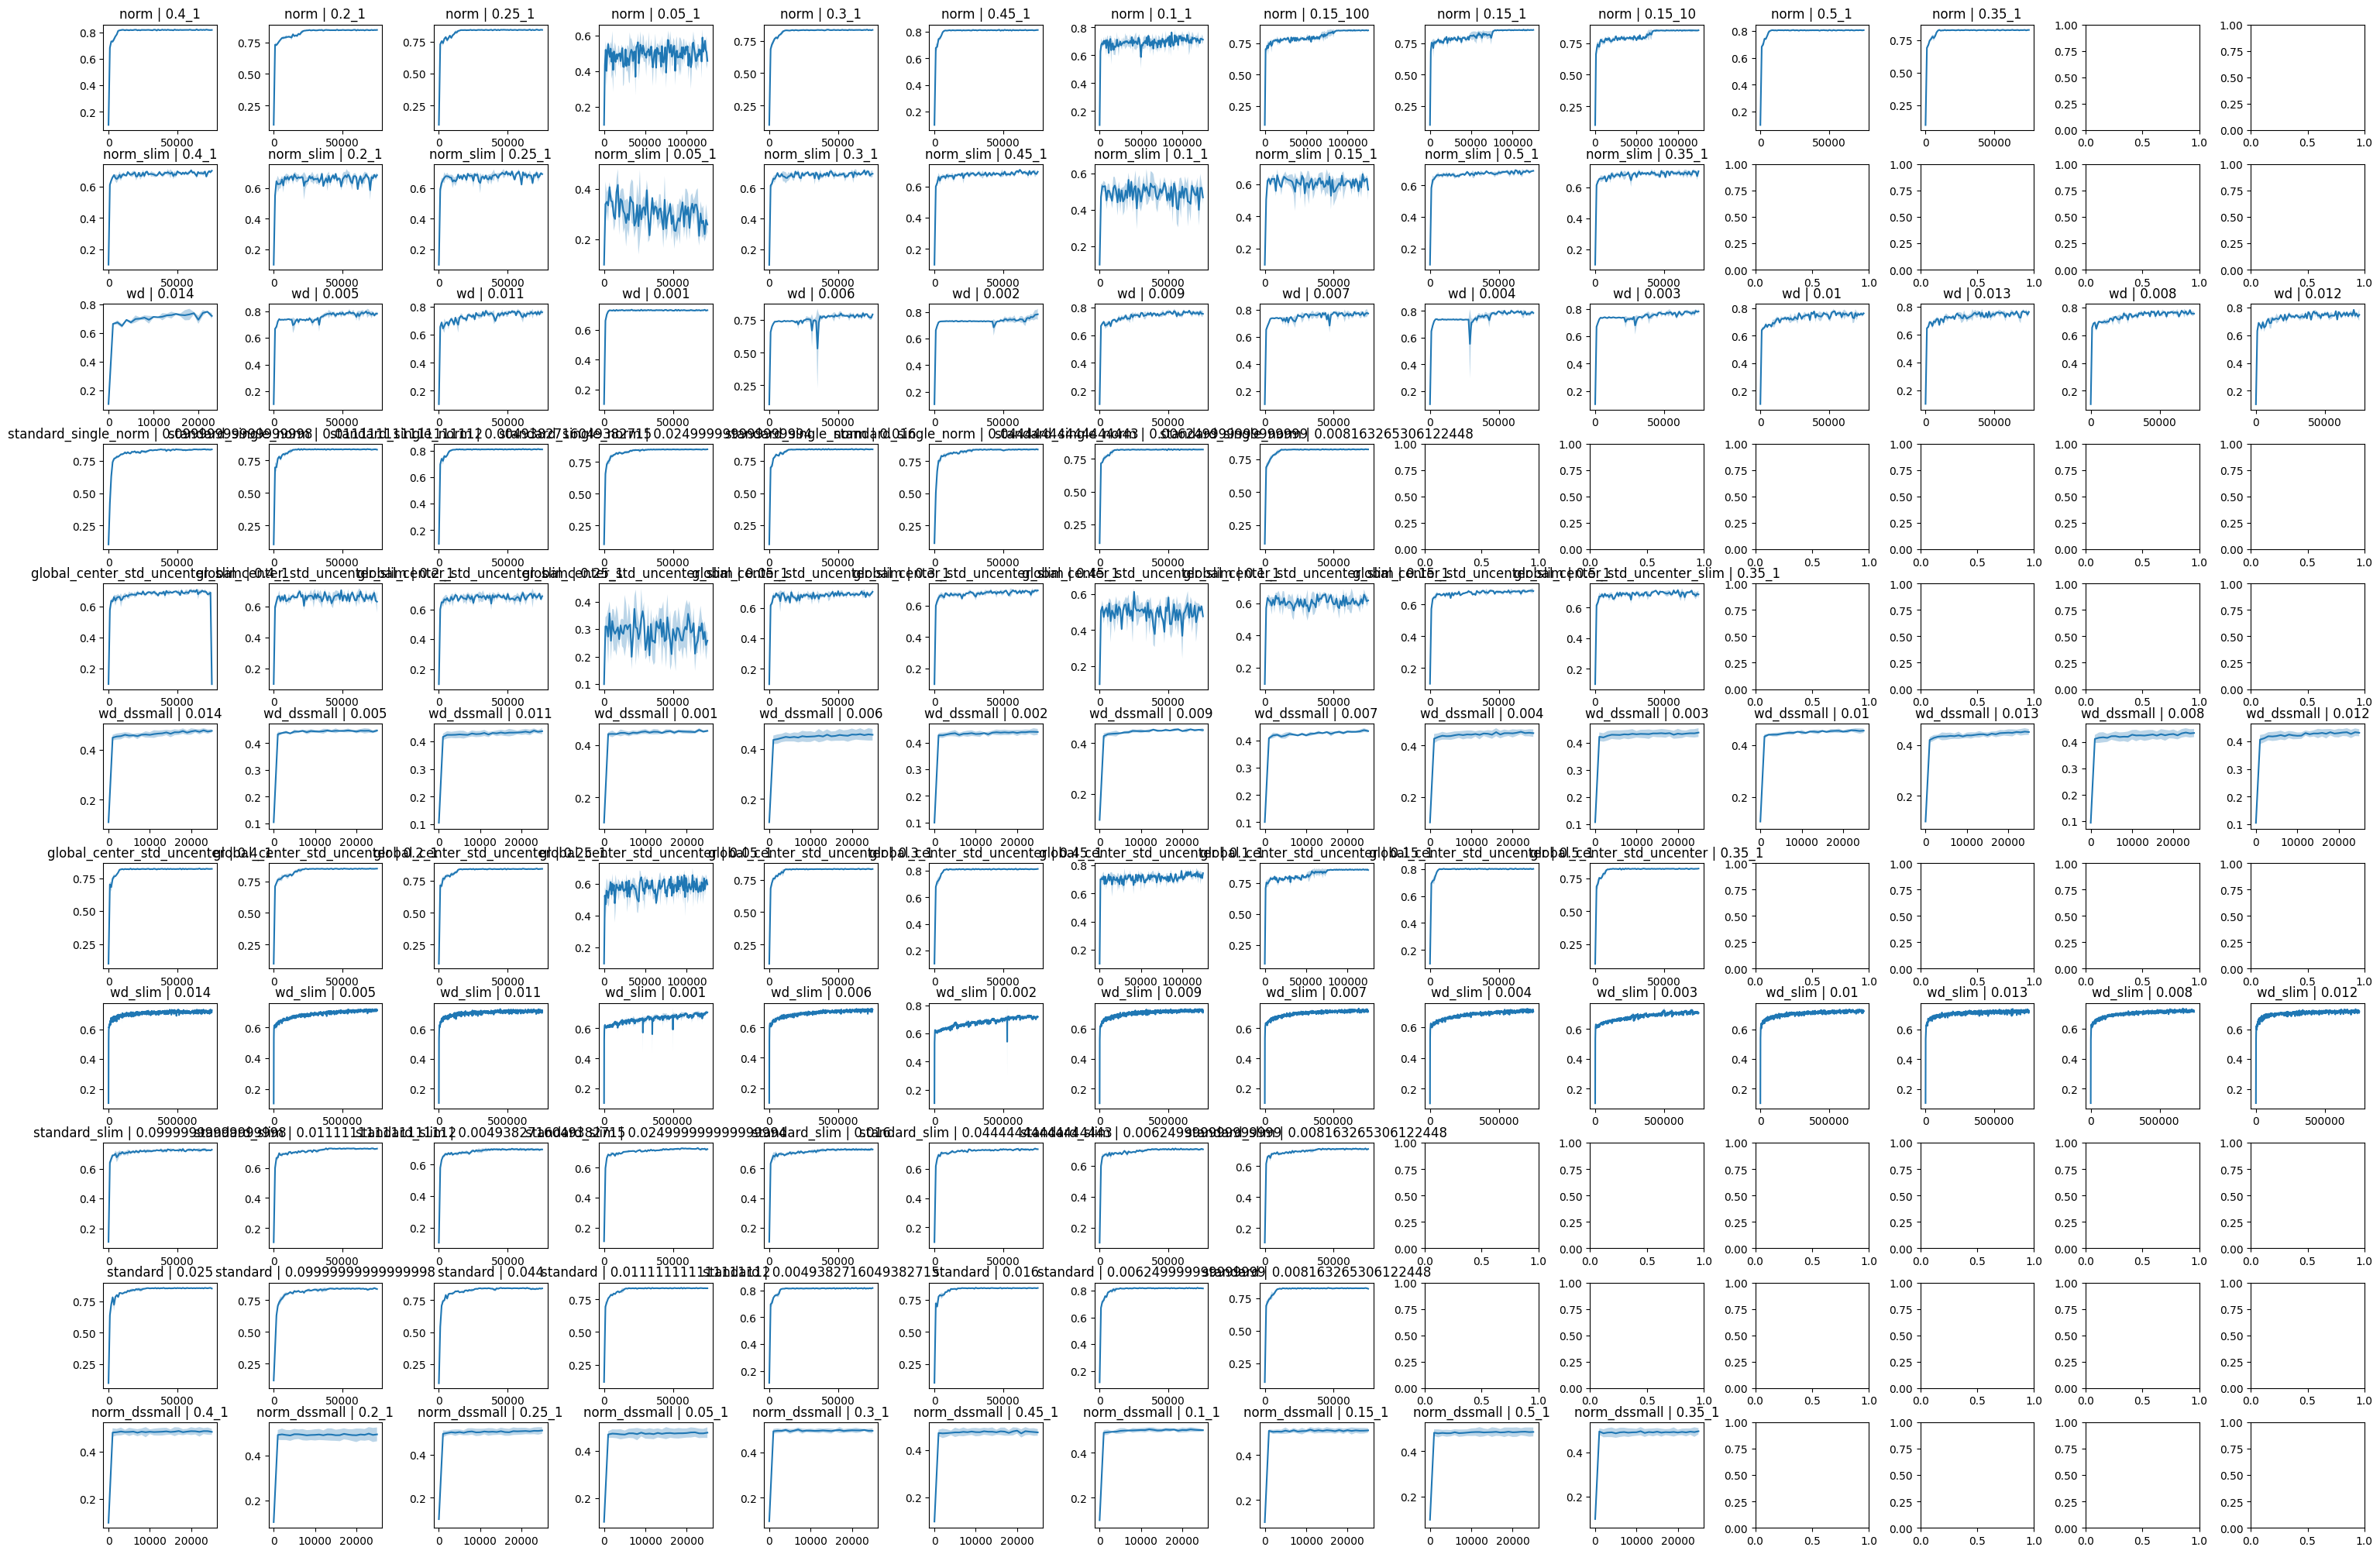

In [27]:


exps = {exp : list(get_subexpspaths(os.path.join("./exps_sgdm",exp))) for exp in os.listdir("./exps_sgdm")}
nrows = len(list(exps.keys()))
ncols = max([len(subexppaths) for subexppaths in exps.values()])

fig,axs = plt.subplots(ncols=ncols,nrows=nrows)
fig.set_size_inches(30,20)
fig.tight_layout()
for row,(exp,subexps) in zip(axs,exps.items()):
    for col,(path,subpath) in zip(row,subexps):
        test_acc = get_stats(path,"test_stats")["acc"]
        plot_step_stat(test_acc,col,)
        col.set_title("{0} | {1}".format(exp,subpath))

In [19]:


def get_batchstats_mean(x, batch_stats):
    batch_stats = tree_map(lambda x : np.asarray(jnp.mean(x)),batch_stats)
    
    mean = {key : {"x" : x, "y" : value["mean"]} for key,value in batch_stats.items()}
    var = {key : {"x" : x, "y" : value["var"]} for key,value in batch_stats.items()}

    return mean,var

def get_weights_channel_norms(x, weights):
    weights = {key : value for key,value in weights.items() if "Conv" in key}
    cnorms = tree_map(lambda w : np.asarray(jnp.linalg.vector_norm(w.reshape(-1,w.shape[-1]),axis=0)),weights)
    mean_and_var_of_cnorms = tree_map(lambda x : (np.mean(x),np.var(x)),cnorms)

    cnorm_mean = {key : {"x" : x, "y" : value["kernel"][0]} for key,value in mean_and_var_of_cnorms.items()}
    cnorm_var = {key : {"x" : x, "y" : value["kernel"][1]} for key,value in mean_and_var_of_cnorms.items()}

    return cnorm_mean,cnorm_var

def get_grad_norm(x, grad):
    gradnorm = tree_map(lambda g : jnp.linalg.norm(g.reshape(-1)),grad)

    gradnorm_bn = np.mean(np.asarray(tree_leaves({key : value for key,value in gradnorm.items() if "BatchNorm" in key})))
    gradnorm_conv = np.mean(np.asarray(tree_leaves({key : value for key,value in gradnorm.items() if "Conv" in key})))
    gradnorm_dense = np.mean(np.asarray(tree_leaves({key : value for key,value in gradnorm.items() if "out" in key})))

    return {"bn" : {"x" : x, "y" : gradnorm_bn},"conv" : {"x" : x, "y" : gradnorm_conv},"dense" : {"x" : x, "y" : gradnorm_dense}}

def get_optim_momentum_norm(x, optim_state):
    optim_state = optim_state[1][0].trace
    momentum_norm = tree_map(lambda g : jnp.linalg.norm(g.reshape(-1)),optim_state)
    
    momentum_norm_bn = np.mean(np.asarray(tree_leaves({key : value for key,value in momentum_norm.items() if "BatchNorm" in key})))
    momentum_norm_conv = np.mean(np.asarray(tree_leaves({key : value for key,value in momentum_norm.items() if "Conv" in key})))
    momentum_norm_dense = np.mean(np.asarray(tree_leaves({key : value for key,value in momentum_norm.items() if "out" in key})))

    return {"bn" : {"x" : x, "y" : momentum_norm_bn},"conv" : {"x" : x, "y" : momentum_norm_conv},"dense" : {"x" : x, "y" : momentum_norm_dense}}

def plot_data(path):
    # Format of dicts in list:
    # rows
    #   cols
    #       title
    #       label
    #            x
    #            y
    row_dict = []

    ckpt_paths_states = get_ckpt_paths(path,"states")
    ckpt_paths_grads = get_ckpt_paths(path,"grads")

    def compute(i,ckpt_states,_,ckpt_grads):

        if not i%5000 == 0:
            return
        
        weights,batch_stats,optim_state = load([ckpt_states])
        grad = load([ckpt_grads])

        batchstats_mean_of_mean,batchstats_var_of_mean = get_batchstats_mean(i, batch_stats)
        cnorm_mean,cnorm_var = get_weights_channel_norms(i,weights)
        gradnorm = get_grad_norm(i, grad)
        momentumnorm = get_optim_momentum_norm(i,optim_state)
        return {
                        0 : 
                            {
                            0 :  
                                ("BatchStats Mean of Mean", batchstats_mean_of_mean) , 
                            1 :  
                                ("BatchStats Var of Mean", batchstats_var_of_mean) 
                            }, 
                        1 : 
                            {
                            0 :  
                                ("Cnorms Mean", cnorm_mean) , 
                            1 :  
                                ("Cnorms Var", cnorm_var) 
                            }, 
                        2 :
                            {
                            0 :
                                ("Grad Norm", gradnorm),
                            1 :
                                ("Momentuum Norm", momentumnorm) 
                            }
                        }    
    
 
    with ThreadPool(processes=12) as pool:
        row_dict = pool.map(lambda x : compute(*list(chain(*x))),zip(list(ckpt_paths_states.items()),list(ckpt_paths_grads.items())))
        

    row_dict = [e for e in row_dict if e is not None]
    row_dict = tree_map(lambda *x : x[0] if isinstance(x[0],str) else np.asarray(x) , *row_dict)

    ncols = len(list(row_dict[0].keys()))
    nrows = len(list(row_dict.keys()))
    fig,axs = plt.subplots(ncols = ncols, nrows = nrows)
    for row,col_dict in row_dict.items():
        for col, (title, label_dict) in col_dict.items():
            if ncols == 1 and nrows == 1:
                ax = plt
            elif ncols == 1:
                ax = axs[row]
            elif nrows == 1:
                ax = axs[col] 
            else:
                ax = axs[row][col]
            for label,x_y_dict in label_dict.items():
                ax.plot(x_y_dict["x"],x_y_dict["y"],label=label)
            
            ax.set_title(title)
            #ax.legend()
    fig.suptitle(path)
    fig.tight_layout()
    fig.set_size_inches(9,5)





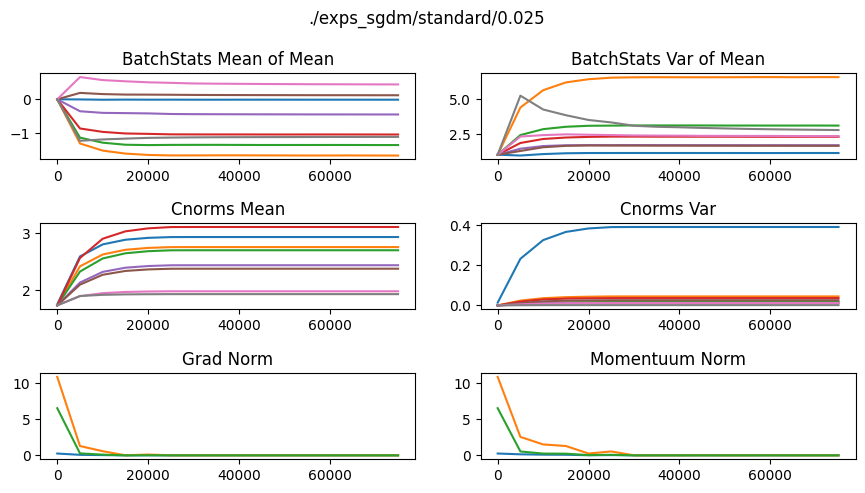

In [21]:
plot_data("./exps_sgdm/standard/0.025")

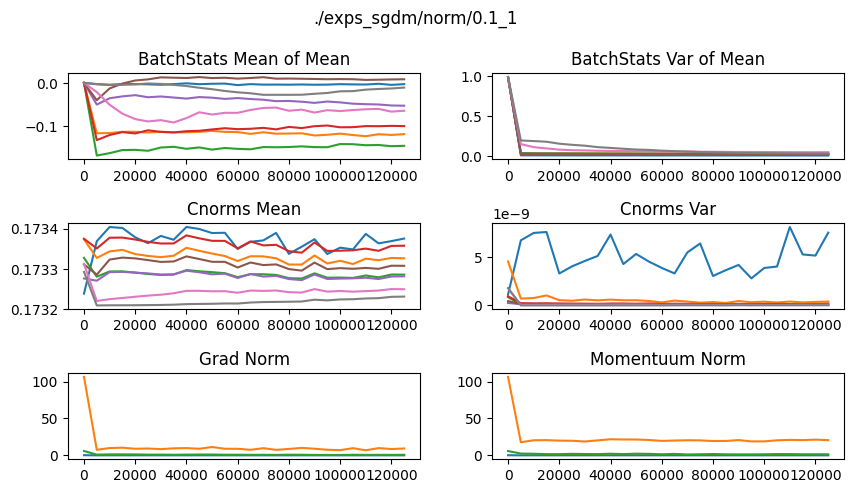

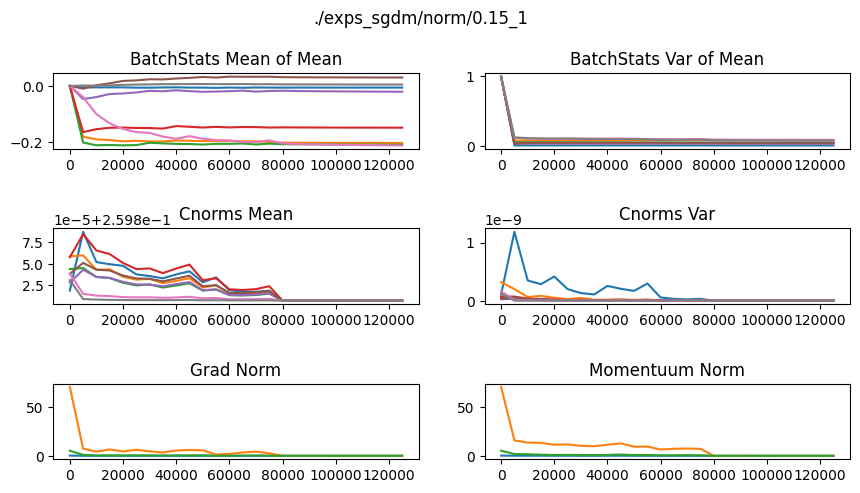

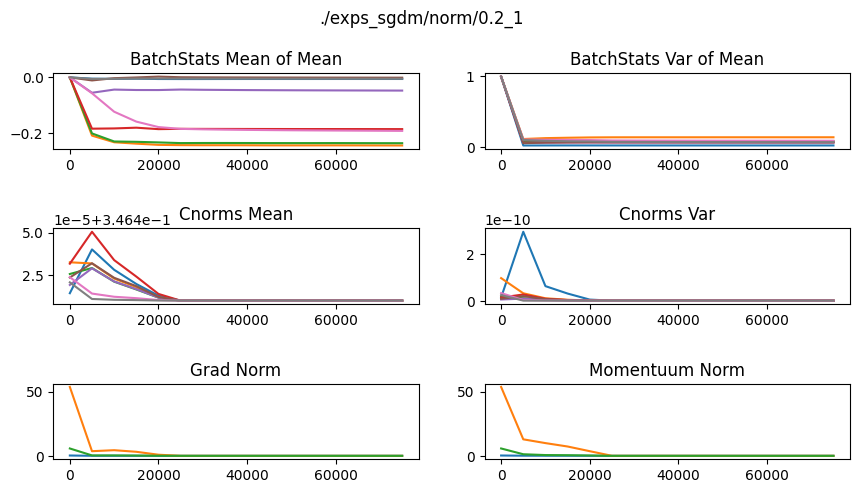

In [64]:
plot_data("./exps_sgdm/norm/0.1_1")
plot_data("./exps_sgdm/norm/0.15_1")
plot_data("./exps_sgdm/norm/0.2_1")

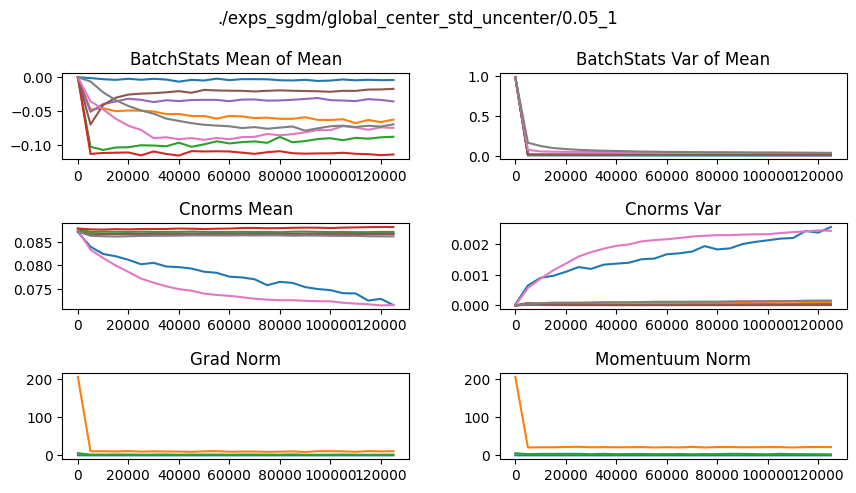

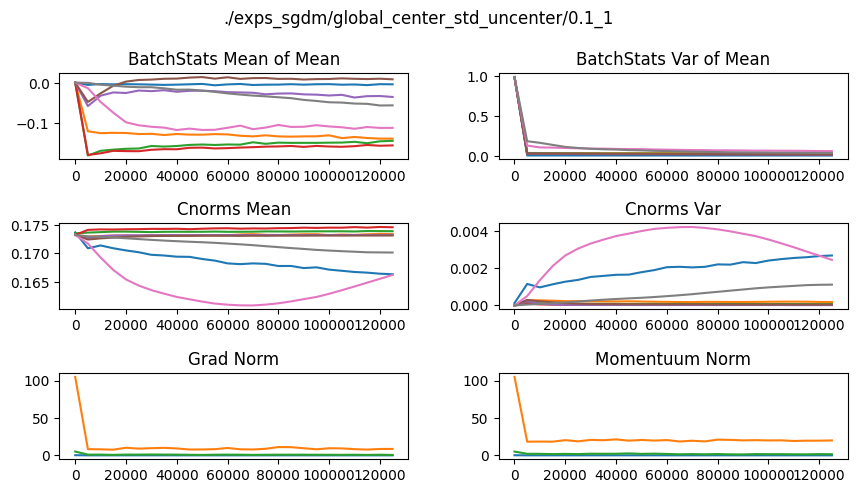

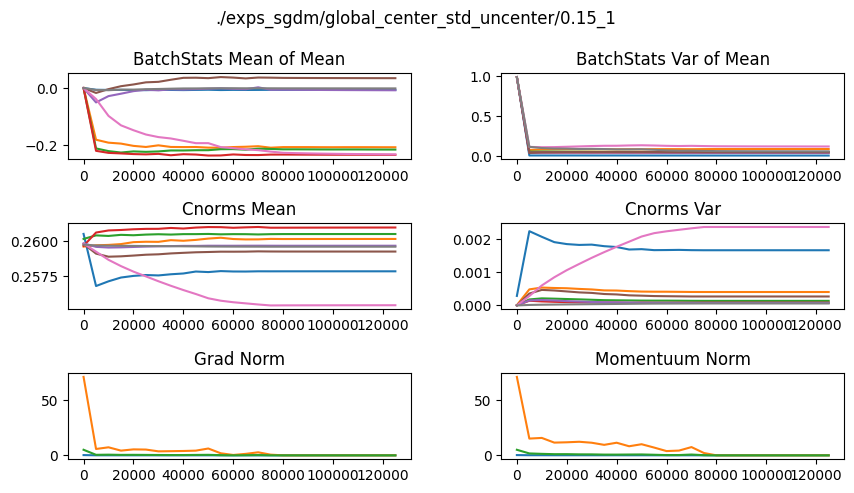

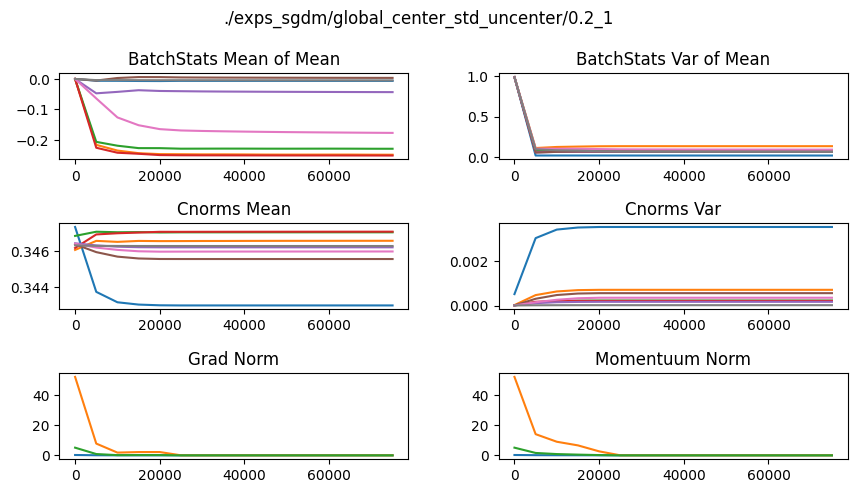

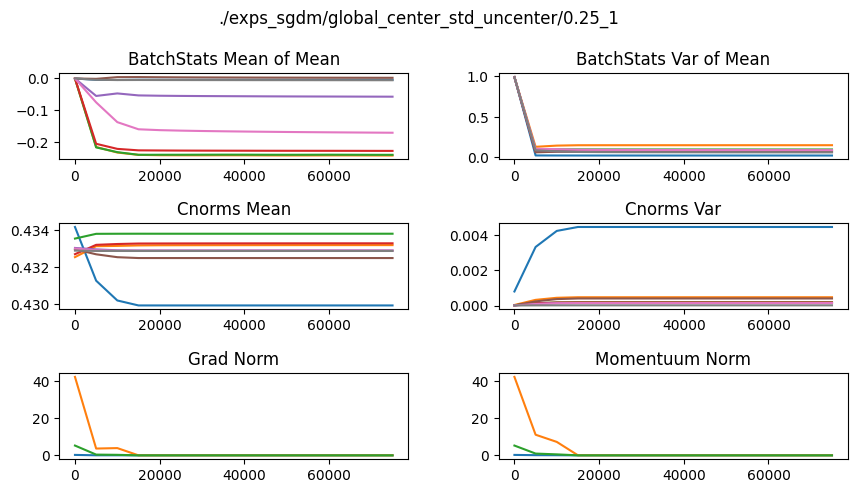

In [65]:
plot_data("./exps_sgdm/global_center_std_uncenter/0.05_1")
plot_data("./exps_sgdm/global_center_std_uncenter/0.1_1")
plot_data("./exps_sgdm/global_center_std_uncenter/0.15_1")
plot_data("./exps_sgdm/global_center_std_uncenter/0.2_1")
plot_data("./exps_sgdm/global_center_std_uncenter/0.25_1")

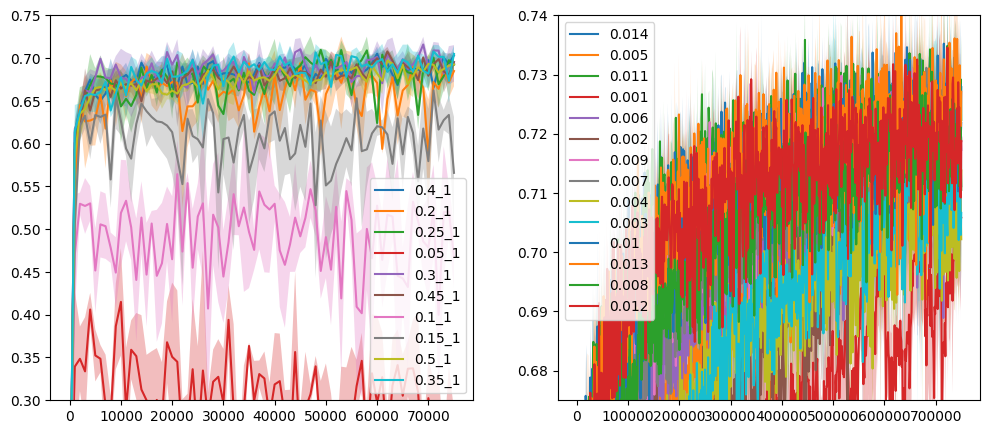

In [18]:
fig,axs = plt.subplots(ncols=2,nrows=1)
fig.set_size_inches(12,5)

for path,subpath in get_subexpspaths("./exps_sgdm/norm_slim"):
    plot_step_stat(get_stats(path, "test_stats")["acc"],axs[0], subpath)
    axs[0].legend()
    axs[0].set_ylim(0.3,0.75)

for path,subpath in get_subexpspaths("./exps_sgdm/wd_slim"):
    plot_step_stat(get_stats(path, "test_stats")["acc"],axs[1], subpath)
    axs[1].legend()
    axs[1].set_ylim(0.675,0.74)